# HR Data Analytics
## Problem
Managerial accounting is used for internal purposes within a business to aid in business decision making. Direct labor costs are an important factor considered by managerial accountants when balancing budgets. Predicting the employees that will be promoted within a given year will aid in predicting future department budget allocations. Given a company’s employee information, classification models can be used to predict the employees that will be promoted in a given year.
## Data
The dataset used is an anonymous company’s HR data in one year obtained from Kaggle. The data is tabular with a size of ~50,000 rows and 14 columns. Each row describes an employee with column features such as “is_promoted,” “age,” “education,” “department,” etc.. The target column, “is_promoted”, is unbalanced because job promotions are generally selective; therefore, the null accuracy will be very high for this dataset.

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
#from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import EditedNearestNeighbours
#from imblearn.combine import SMOTEENN, SMOTETomek

#from sklearn.linear_model import LogisticRegression, SGDClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
#from sklearn.neighbors import KNeighborsClassifier 
#from sklearn.svm import SVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.neural_network import MLPClassifier
#from lightgbm import LGBMClassifier
#from xgboost.sklearn import XGBClassifier

#from sklearn.model_selection import GridSearchCV, cross_val_score
#from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
#from sklearn import metrics
#from sklearn.metrics import roc_curve, auc, roc_auc_score

#from time import time

# Load Data

In [3]:
hr_df = pd.read_csv("Data/hr_data.csv")

The dataset is split into train and test subsets.\
All the exploratory data analysis will be performed on the training subset.\
The test subset will be unmodified and will only be used for testing model performance.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    hr_df.drop(labels="is_promoted", axis=1), hr_df["is_promoted"], 
    test_size=0.2, 
    stratify=hr_df["is_promoted"], #Preserves proportion of labels between train and test data
    random_state=42, #Ensures same shuffling throughout each run
)

In [5]:
train_df = X_train
train_df["is_promoted"] = y_train

In [6]:
test_df = X_test
test_df["is_promoted"] = y_test
test_df = test_df.dropna() #null values are dropped from test set. Null values cannot be imputed in test data.

# Exploratory Data Analysis
After loading HR data, data must be analyzed and the following will be considered:
1. Feature data types
2. Univariate analysis
3. Outlier values
4. Missing values
5. Bivariate analysis

In [7]:
train_df.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
25890,69764,Operations,region_2,Bachelor's,f,sourcing,1,54,3.0,19,0,0,62,0
24121,16669,Procurement,region_16,Master's & above,f,sourcing,1,39,5.0,10,1,0,70,0
483,78119,Procurement,region_11,Bachelor's,f,other,1,36,3.0,4,1,0,72,0
14389,46952,Sales & Marketing,region_13,Master's & above,m,other,1,40,3.0,2,0,0,51,0
45182,26755,Technology,region_27,Master's & above,m,other,2,41,3.0,5,0,0,82,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43846 entries, 25890 to 54230
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           43846 non-null  int64  
 1   department            43846 non-null  object 
 2   region                43846 non-null  object 
 3   education             41946 non-null  object 
 4   gender                43846 non-null  object 
 5   recruitment_channel   43846 non-null  object 
 6   no_of_trainings       43846 non-null  int64  
 7   age                   43846 non-null  int64  
 8   previous_year_rating  40548 non-null  float64
 9   length_of_service     43846 non-null  int64  
 10  KPIs_met >80%         43846 non-null  int64  
 11  awards_won?           43846 non-null  int64  
 12  avg_training_score    43846 non-null  int64  
 13  is_promoted           43846 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.0+ MB


In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
employee_id,43846.0,39183.284222,22588.584353,2.0,19669.5,39158.0,58692.5,78298.0
no_of_trainings,43846.0,1.251699,0.603979,1.0,1.0,1.0,1.0,10.0
age,43846.0,34.809903,7.671533,20.0,29.0,33.0,39.0,60.0
previous_year_rating,40548.0,3.332865,1.261369,1.0,3.0,3.0,4.0,5.0
length_of_service,43846.0,5.859759,4.260014,1.0,3.0,5.0,7.0,34.0
KPIs_met >80%,43846.0,0.352278,0.477686,0.0,0.0,0.0,1.0,1.0
awards_won?,43846.0,0.022670,0.148852,0.0,0.0,0.0,0.0,1.0
avg_training_score,43846.0,63.378621,13.361344,39.0,51.0,60.0,76.0,99.0
is_promoted,43846.0,0.085162,0.279125,0.0,0.0,0.0,0.0,1.0


In [10]:
train_df.nunique()

employee_id             43846
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          34
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

## Feature Data Types
### Nominal Categorical Data
"employee_id" -- Employee id's are unique identifiers which are arbitrarily assigned. This variable is not helpful in predicting promotions, so it will be dropped.\
\
"department", "gender", "region", "recruitment_channel" -- These features are categorical and do not have an intrinsic ordering.\
\
"KPIs_met >80%", "awards_won?", "is_promoted" -- These features are binary with no ordering.
### Ordinal Categorical Data
"education" -- Education is categorical and adheres to ordered levels of study\
\
"previous_year_rating" -- There are only five levels of previous year ratings in this company. These ratings do not represent a count or true measurement.
### Interval Quantitative Data
There are no instances of interval quantitative data in this dataset. All of the quantitative features have an absolute zero.
### Ratio Quantitative Data
"no_of_trainings", "age", "avg_training_score", "length_of_service" -- These features can be measured and have absolute zeros. In this dataset, all the numerical features happen to be discrete.

## Data Separation
The data is separated by data type to prepare for basic analysis.
### Categorical Features

In [11]:
categorical_df = train_df.select_dtypes(include="object")
categorical_df["KPIs_met >80%"] = train_df["KPIs_met >80%"]
categorical_df["awards_won?"] = train_df["awards_won?"]
categorical_df["previous_year_rating"] = train_df["previous_year_rating"]
categorical_df["is_promoted"] = train_df["is_promoted"]
categorical_df.head(3)

,department,region,education,gender,recruitment_channel,KPIs_met >80%,awards_won?,previous_year_rating,is_promoted
25890,Operations,region_2,Bachelor's,f,sourcing,0,0,3.0,0
24121,Procurement,region_16,Master's & above,f,sourcing,1,0,5.0,0
483,Procurement,region_11,Bachelor's,f,other,1,0,3.0,0


### Numerical Features

In [12]:
numerical_df = train_df.select_dtypes(include="number")
numerical_df = numerical_df.drop(
    labels=["employee_id", "awards_won?", "previous_year_rating", "KPIs_met >80%", "is_promoted"], axis=1)
numerical_df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_trainings,43846.0,1.251699,0.603979,1.0,1.0,1.0,1.0,10.0
age,43846.0,34.809903,7.671533,20.0,29.0,33.0,39.0,60.0
length_of_service,43846.0,5.859759,4.260014,1.0,3.0,5.0,7.0,34.0
avg_training_score,43846.0,63.378621,13.361344,39.0,51.0,60.0,76.0,99.0


## Univariate Analysis
The distributions of each feature are analyzed
### Numerical Univariate Analysis
Histograms are used to view the distributions of numerical features.\
Boxplots are used after to aid in viewing outliers.\
Analyzing the distribution of numerical features aids in outlier identification, and imputation for outliers or missing-values.

NameError: name 'df' is not defined

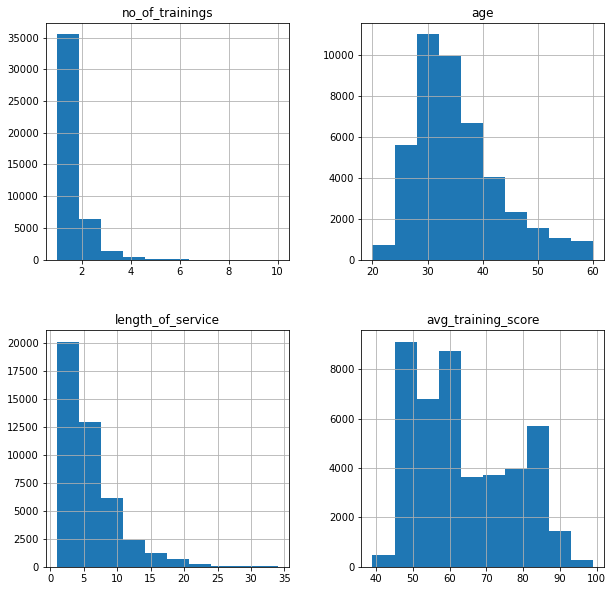

In [17]:
fig, ax = plt.subplots(figsize=(10,10), facecolor="white")
figure = numerical_df.hist(ax=ax)
df.hist(ax=ax)
for ax in figure.flatten():
    ax.set_ylabel("Count", labelpad=5)

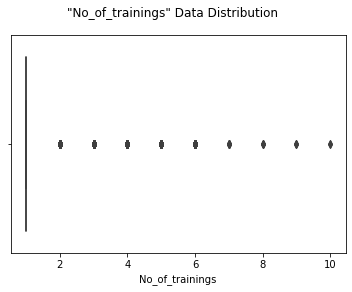

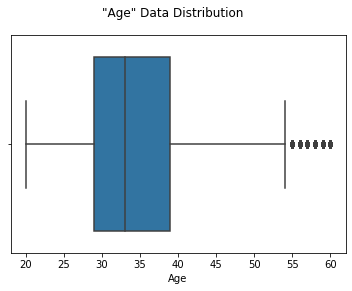

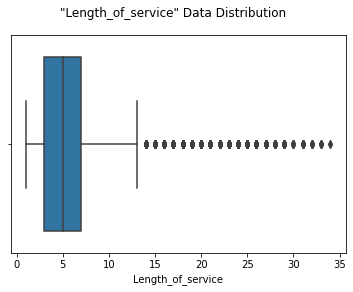

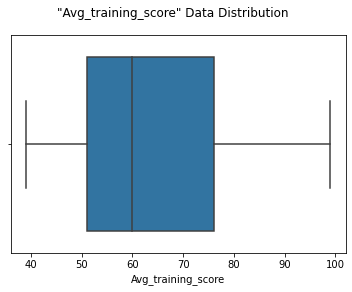

In [14]:
for data in numerical_df.columns:
    fig, ax = plt.subplots(facecolor="white")
    sns.boxplot(numerical_df[data])
    fig.suptitle(f'"{ax.get_xlabel().capitalize()}" Data Distribution')
    ax.set_xlabel(ax.get_xlabel().capitalize())
    ax.set_ylabel(ax.get_ylabel().capitalize())

### Categorical Univariate Analysis
Analyzing the distribution of categorical features aids in imputation for missing-values.\
In addition, these figures show that the target feature, "is_promoted", is imbalanced.

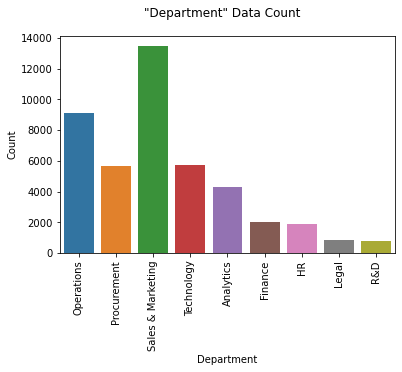

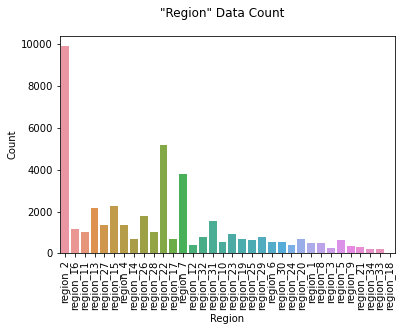

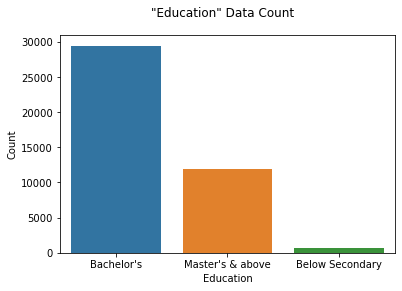

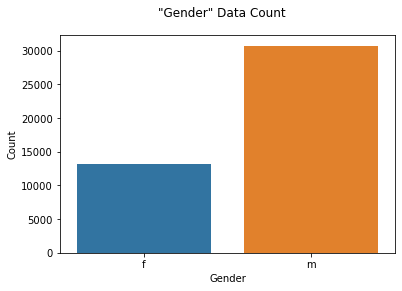

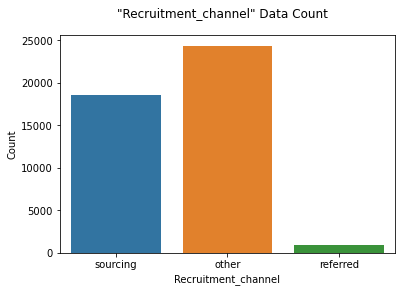

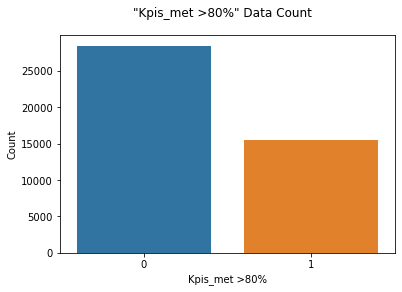

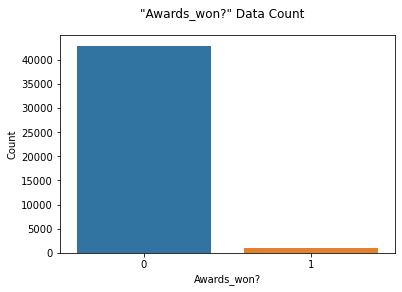

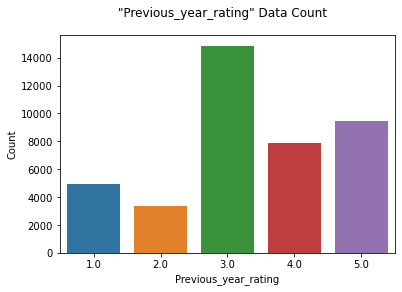

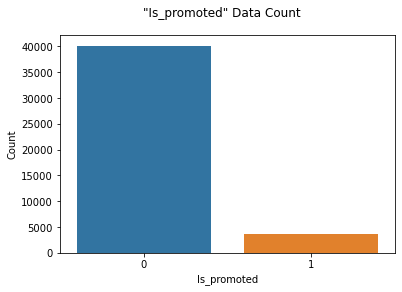

In [18]:
for category in categorical_df.columns:
    fig, ax = plt.subplots(facecolor="white")
    sns.countplot(categorical_df[category])
    fig.suptitle(f'"{ax.get_xlabel().capitalize()}" Data Count')
    ax.set_xlabel(ax.get_xlabel().capitalize())
    ax.set_ylabel(ax.get_ylabel().capitalize())
    if len(categorical_df[category].unique()) > 8:
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)

## Outlier Values
All the numerical data, except "avg_training_score", have at least one outlier. Upon close inspection, the outlier values were determined to not be due to error in measurements. Therefore, it was decided to not remove or impute the values.

## Missing Values
There appears to be missing values in "education" and "previous_year_rating"

In [19]:
train_df.isna().sum()

employee_id                0
department                 0
region                     0
education               1900
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    3298
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

The missing values in "education" were imputed with the mode category, "Bachelor's Education".\
The missing values in "previous_year_rating" were imputed with the mode rating, "3".
>The imputation may be improved by using a nearest neighbor algorithm (sklearn.impute.KNNImputer)

In [20]:
train_df["education"].fillna(train_df["education"].mode()[0],inplace=True)
train_df["previous_year_rating"].fillna(train_df["previous_year_rating"].mode()[0],inplace=True)
categorical_df["education"].fillna(categorical_df["education"].mode()[0],inplace=True)
categorical_df["previous_year_rating"].fillna(categorical_df["previous_year_rating"].mode()[0],inplace=True)
train_df.isna().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

## Bivariate Analysis
Features are compared with target value "is_promoted"
### Numerical Bivariate Analysis
Out of the numerical features, it appears that "avg_training_score" has different mean values for each "is_promoted" target; employees that were promoted tend to have a higher average training score.

In [0]:
for data in numerical_df.columns:
    fig, ax = plt.subplots(facecolor="white")
    sns.boxplot(x="is_promoted", y=data, data=train_df)
    ax.set_xlabel(ax.get_xlabel().capitalize())
    ax.set_ylabel(ax.get_ylabel().capitalize())

### Categorical Bivariate Analysis
There are noticeable differences in promotion among the "KPIs Met >80%", "Awards Won?", and "Previous Year Rating" features.

In [0]:
for category in categorical_df.drop(labels="is_promoted", axis=1).columns:
    fig, ax = plt.subplots(facecolor="white")
    #sns.countplot(categorical_df[category], hue=categorical_df["is_promoted"])
    data = pd.crosstab(categorical_df[category], categorical_df["is_promoted"])
    data.div(data.sum(1).astype('float'),axis=0).plot(kind='bar', stacked=True, ax=ax)

    fig.suptitle(f'"{ax.get_xlabel().capitalize()}" Proportion "Is_promoted"')
    ax.set_xlabel(ax.get_xlabel().capitalize())
    ax.set_ylabel(ax.get_ylabel().capitalize())
    if len(categorical_df[category].unique()) > 8:
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)

# Data Processing
## Correlation Heatmap
Pairs of features with high absolute correlations must be corrected by removing one of the correlated features.\
As shown by the correlation matrix, the numerical features and binary features do not appear to be highly correlated. Numerical features and binary features will not be removed from this step. Some binary features may be removed after a Chi-Square test of independence.

In [0]:
    binary_df = categorical_df[["gender","KPIs_met >80%","awards_won?","is_promoted"]]
binary_df["gender"] = binary_df["gender"].replace({"f":1,"m":0})

NameError: name 'binary_df' is not defined

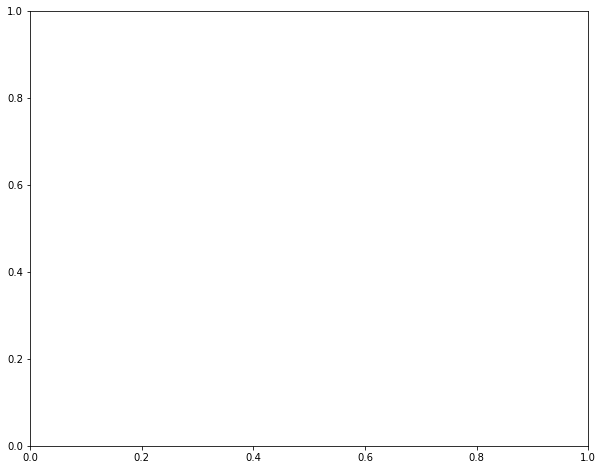

In [21]:
fig, ax = plt.subplots(figsize=(10,8), facecolor="white")
sns.heatmap(pd.concat([numerical_df, binary_df], axis=1).corr(), ax=ax,
            linewidths=0.5, annot=True, cmap=sns.color_palette("Greens"))
ax.set_title("Correlation Heatmap of HR Data", pad=10, fontsize = 20)

## Categorical Feature Selection
A Chi-Square test of independence is used to find the relationship between the input features and output feature.\
The Chi-Square test of independence assumes the null hypothesis "each input feature and target feature are independent of each other."\
If the p-value is less than the decided significance value, the null hypothesis is rejected; there is a statistically significant association between the input feature and target feature.

In [22]:
chi2_feature_df = categorical_df.drop(labels="is_promoted", axis=1)
chi2_feature_df["gender"] = chi2_feature_df["gender"].replace({"f":1,"m":0})
chi2_feature_df["education"] = chi2_feature_df["education"].replace({"Master's & above":2, "Bachelor's":1, "Below Secondary":0})
chi2_feature_df = pd.get_dummies(chi2_feature_df)

It was found that removing categorical features with p-values greater than 0.2 improved model performances the most.

In [23]:
chi2_out = SelectKBest(chi2, k="all").fit(chi2_feature_df, categorical_df["is_promoted"])
chi2_out_df = pd.DataFrame(np.array([chi2_out.pvalues_, chi2_out.scores_]).T,
                         index=chi2_feature_df.columns, 
                         columns=["pvalue", "score"])
remove_df = chi2_out_df[chi2_out_df["pvalue"] > 0.20]
remove_df.index

Index(['department_Finance', 'department_R&D', 'region_region_1',
       'region_region_10', 'region_region_13', 'region_region_14',
       'region_region_15', 'region_region_18', 'region_region_30',
       'region_region_8', 'recruitment_channel_other',
       'recruitment_channel_sourcing'],
      dtype='object')

# Project Visualizations
Interactive figures used for project website

In [24]:
fig_title_size = 20
axes_title_size = 17
#write_html = False

## Numerical Feature Histograms
This figure was used for data cleaning.

In [25]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Age", "No. of Trainings", "Avg. Training Score", "Length of Service"),
)

trace0 = go.Histogram(x=numerical_df["age"], hoverlabel=dict(namelength=0))
trace1 = go.Histogram(x=numerical_df["no_of_trainings"], hoverlabel=dict(namelength=0))
trace2 = go.Histogram(x=numerical_df["avg_training_score"], hoverlabel=dict(namelength=0))
trace3 = go.Histogram(x=numerical_df["length_of_service"], hoverlabel=dict(namelength=0))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig.update_layout( 
    title="Numerical Feature Histograms",
    showlegend=False,
    width=700, height=550
)

fig['layout']['title']['font']['size'] = fig_title_size
for annotation in fig['layout']['annotations']:
    annotation.font.size = axes_title_size

#if write_html:
#    fig.write_html("numerical_histogram.html")
fig.show()

## Categorical Feature Bar Charts
This figure was used for data cleaning.

In [26]:
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=(
        "Gender","Recruitment Channel","previous_year_rating", "KPIs Met >80%",
        "Awards Won?","Is Promoted", "Department","Region","Education"),
)

data_vc = categorical_df["gender"].value_counts()
categories, values = list(data_vc.index), data_vc.to_numpy()
trace = go.Bar(x=categories, y=values, hoverlabel=dict(namelength=0))
fig.append_trace(trace, 1, 1)

data_vc = categorical_df["recruitment_channel"].value_counts()
categories, values = list(data_vc.index), data_vc.to_numpy()
trace = go.Bar(x=categories, y=values, hoverlabel=dict(namelength=0))
fig.append_trace(trace, 1, 2)

data_vc = categorical_df["previous_year_rating"].value_counts()
categories, values = list(data_vc.index), data_vc.to_numpy()
trace = go.Bar(x=categories, y=values, hoverlabel=dict(namelength=0))
fig.append_trace(trace, 1, 3)

data_vc = categorical_df["KPIs_met >80%"].value_counts()
categories, values = list(data_vc.index), data_vc.to_numpy()
trace = go.Bar(x=["No", "Yes"], y=values, hoverlabel=dict(namelength=0))
fig.append_trace(trace, 2, 1)

data_vc = categorical_df["awards_won?"].value_counts()
categories, values = list(data_vc.index), data_vc.to_numpy()
trace = go.Bar(x=["No", "Yes"], y=values, hoverlabel=dict(namelength=0))
fig.append_trace(trace, 2, 2)

data_vc = hr_df["is_promoted"].value_counts()
categories, values = list(data_vc.index), data_vc.to_numpy()
trace = go.Bar(x=["No", "Yes"], y=values, hoverlabel=dict(namelength=0))
fig.append_trace(trace, 2, 3)

data_vc = categorical_df["department"].value_counts()
categories, values = list(data_vc.index), data_vc.to_numpy()
trace = go.Bar(x=categories, y=values, hoverlabel=dict(namelength=0))
fig.append_trace(trace, 3, 1)

data_vc = categorical_df["region"].value_counts()
categories, values = list(data_vc.index), data_vc.to_numpy()
trace = go.Bar(x=categories, y=values, hoverlabel=dict(namelength=0))
fig.append_trace(trace, 3, 2)

data_vc = categorical_df["education"].value_counts()
categories, values = list(data_vc.index), data_vc.to_numpy()
trace = go.Bar(x=categories, y=values, hoverlabel=dict(namelength=0))
fig.append_trace(trace, 3, 3)

fig.update_layout( 
    title="Categorical Feature Bar Charts",
    showlegend=False,
    width=888, height=700
)

fig['layout']['title']['font']['size'] = fig_title_size
for annotation in fig['layout']['annotations']:
    annotation.font.size = axes_title_size

#if write_html:
#    fig.write_html("categorical_barchart.html")
fig.show()

## Numerical Features vs Promotion Distributions
This figure was used to identify simple trends in promotions.

In [27]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("No. of Trainings", "Age", "Avg. Training Score", "Length of Service"),
)
trace0 = go.Box(y=numerical_df["no_of_trainings"],
                x=categorical_df["is_promoted"].replace({0:"not promoted", 1:"promoted"}),
                hoverlabel=dict(namelength=0))
trace1 = go.Box(y=numerical_df["age"],
                x=categorical_df["is_promoted"].replace({0:"not promoted", 1:"promoted"}),
                hoverlabel=dict(namelength=0))
trace2 = go.Box(y=numerical_df["avg_training_score"],
                x=categorical_df["is_promoted"].replace({0:"not promoted", 1:"promoted"}),
                hoverlabel=dict(namelength=0))
trace3 = go.Box(y=numerical_df["length_of_service"],
                x=categorical_df["is_promoted"].replace({0:"not promoted", 1:"promoted"}),
                hoverlabel=dict(namelength=0))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig.update_layout(
    title="Numerical Features vs Promotion Distributions",
    showlegend=False,
    width=700, height=550
)

fig['layout']['title']['font']['size'] = fig_title_size
for annotation in fig['layout']['annotations']:
    annotation.font.size = axes_title_size

#if write_html:
#    fig.write_html("numerical_promotion_boxplot.html")
fig.show()

## Categorical Features vs Promotion Proportions
This figure was used to identify simple trends in promotions.

In [28]:
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=(
        "Recruitment Channel","Previous Year Rating", "KPIs Met >80%",
        "Awards Won?","Gender","Education","Department","Region"),
    vertical_spacing = 0.15,
)

data = pd.crosstab(categorical_df["recruitment_channel"], categorical_df["is_promoted"])
data = data.div(data.sum(1).astype('float'),axis=0)
trace = go.Bar(x=data.index, y=data[0], offsetgroup=0, name="not promoted")
fig.append_trace(trace, 1, 1)
trace = go.Bar(x=data.index, y=data[1], offsetgroup=0, base=data[0], name="promoted")
fig.append_trace(trace, 1, 1)

data = pd.crosstab(categorical_df["previous_year_rating"], categorical_df["is_promoted"])
data = data.div(data.sum(1).astype('float'),axis=0)
trace = go.Bar(x=data.index, y=data[0], offsetgroup=0, name="not promoted")
fig.append_trace(trace, 1, 2)
trace = go.Bar(x=data.index, y=data[1], offsetgroup=0, base=data[0], name="promoted")
fig.append_trace(trace, 1, 2)

data = pd.crosstab(categorical_df["KPIs_met >80%"], categorical_df["is_promoted"])
data = data.div(data.sum(1).astype('float'),axis=0)
trace = go.Bar(x=["No", "Yes"], y=data[0], offsetgroup=0, name="not promoted")
fig.append_trace(trace, 1, 3)
trace = go.Bar(x=["No", "Yes"], y=data[1], offsetgroup=0, base=data[0], name="promoted")
fig.append_trace(trace, 1, 3)

data = pd.crosstab(categorical_df["awards_won?"], categorical_df["is_promoted"])
data = data.div(data.sum(1).astype('float'),axis=0)
trace = go.Bar(x=["No", "Yes"], y=data[0], offsetgroup=0, name="not promoted")
fig.append_trace(trace, 2, 1)
trace = go.Bar(x=["No", "Yes"], y=data[1], offsetgroup=0, base=data[0], name="promoted")
fig.append_trace(trace, 2, 1)

data = pd.crosstab(categorical_df["gender"], categorical_df["is_promoted"])
data = data.div(data.sum(1).astype('float'),axis=0)
trace = go.Bar(x=["Female", "Male"], y=data[0], offsetgroup=0, name="not promoted")
fig.append_trace(trace, 2, 2)
trace = go.Bar(x=["Female", "Male"], y=data[1], offsetgroup=0, base=data[0], name="promoted")
fig.append_trace(trace, 2, 2)

data = pd.crosstab(categorical_df["education"], categorical_df["is_promoted"])
data = data.div(data.sum(1).astype('float'),axis=0)
trace = go.Bar(x=data.index, y=data[0], offsetgroup=0, name="not promoted")
fig.append_trace(trace, 2, 3)
trace = go.Bar(x=data.index, y=data[1], offsetgroup=0, base=data[0], name="promoted")
fig.append_trace(trace, 2, 3)

data = pd.crosstab(categorical_df["department"], categorical_df["is_promoted"])
data = data.div(data.sum(1).astype('float'),axis=0)
trace = go.Bar(x=data.index, y=data[0], offsetgroup=0, name="not promoted")
fig.append_trace(trace, 3, 1)
trace = go.Bar(x=data.index, y=data[1], offsetgroup=0, base=data[0], name="promoted")
fig.append_trace(trace, 3, 1)

data = pd.crosstab(categorical_df["region"], categorical_df["is_promoted"])
data = data.div(data.sum(1).astype('float'),axis=0)
trace = go.Bar(x=data.index, y=data[0], offsetgroup=0, name="not promoted")
fig.append_trace(trace, 3, 2)
trace = go.Bar(x=data.index, y=data[1], offsetgroup=0, base=data[0], name="promoted")
fig.append_trace(trace, 3, 2)

fig.update_layout(
    title="Categorical Features vs Promotion Proportions",
    showlegend=False,
    width=888, height=700
)

fig['layout']['title']['font']['size'] = fig_title_size
for annotation in fig['layout']['annotations']:
    annotation.font.size = axes_title_size

#if write_html:
#    fig.write_html("categorical_promotion_barchart.html")
fig.show()

## Correlation Heatmap
This figure was used for numerical feature and binary feature selection.\
In this project, no numerical features or binary features were omitted.

In [29]:
fig = px.imshow(pd.concat([numerical_df, binary_df], axis=1).corr(),
                width=888, height=700, text_auto=True, labels={"color": "Correlation"},
                color_continuous_scale="RdBu", range_color=(-1,1))
fig.update_layout(title={
    'text': "Correlation Heatmap",
    'font': {'size': fig_title_size},
    'y': 0.96})

#if write_html:
#    fig.write_html("correlation_heatmap.html")
fig.show()

NameError: name 'binary_df' is not defined

## Categorical Feature P-Value Distribution 
This figure was used for categorical feature selection.\
For this project, features with a p-value greater than 0.2 were omitted.

In [0]:
chi2_sort_df = chi2_out_df.sort_values(by="pvalue")
fig = px.bar(x=chi2_sort_df.index, y=chi2_sort_df["pvalue"], color = (chi2_sort_df["pvalue"] > 0.2),
            labels={"x":"Feature", "y": "P-Value", "color": "Omitted"})
fig.update_layout(
    title={'text':"Categorical Feature P-Value Distribution",
        'font': {'size': fig_title_size}},
    xaxis={'title':{'font': {'size': axes_title_size}}},
    yaxis={'title':{'font': {'size': axes_title_size}}},
    showlegend=False, width=888, height=500)

#if write_html:
#    fig.write_html("categorical_pvalues.html")
fig.show()